Creator: Yen Ting Lin, CCS-3, LANL 

Note: For the manuscript "*Gene expression noise accelerates the evolution of a biological oscillator*", co-authored by Nicolas E. Buchler, NCSU

The code has been reviewed by Richard P. Feynman Center for Innovation at the Los Alamos National Laboratory, with a C number C21109

This notebook simulates the evolutionary processes of three biophysical parameters $\beta^F_X$, $\beta^B_X$, and $\Omega$ for gene expression dynamics. For $\Omega>10^5$ we used deterministic simulator, and for $\Omega<10^5$ we used CTMC (Gillespie) simulator. 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import cm 

from multiprocessing import Pool
from subprocess import call, STDOUT

from scipy import signal
import matplotlib.mlab as mlab
from scipy.stats import norm, uniform, multivariate_normal

from scipy.spatial import ConvexHull
from matplotlib.path import Path

In [2]:
plt.rcParams.update({'font.size':14})

In [3]:
initial2Dlocations = np.array([
    [20, 165, 4],
    [20, 300, 4],
    [25, 210, 4],
    [25, 260, 4],
    [9 , 165, 4],
    [7 , 210, 4],
    [6.5 , 260, 4],
    [9 , 310, 4],
])

In [4]:
mutationCovDiag = 0.01*np.array([1.0, 40, 10])

In [5]:
rep = 1  # Replica index. For the paper, we ran 5 replica and made sure the observations are robust 
globalIndex = rep

In [6]:
populationN = 100
poolN = populationN
tSpan = np.linspace(0, 50, 10001)

In [7]:
par = {'kappaX':1.2,
       'kappaY':0.9,
       'theta':1,
       'nA':3,
       'nB':3,
       'alpha':10,
       'betaBX':200,
       'betaFX':12,
       'betaBY':400,
       'betaFY':10,
       'deltaX':1.,
       'deltaY':0.05,}

def H(x,kappa,theta,N):
    
    prob=np.ones([1,N+1])
    
    for i in range(1,N+1):
        prob[0,i] = prob[0,i-1] * kappa * x  / theta 
    
    total=0
    
    for i in range(N+1):
        total += prob[0,i]
    
    return prob[0][N]/total


def RHS(t,z,par):
    
    x,y  = z
    
    dxdt =  par['betaFX'] + (par['betaBX']-par['betaFX'])*H(x,par['kappaX'],par['theta'],3)-par['deltaX']*x - par['alpha']*x*y
    dydt =  par['betaFY'] + (par['betaBY']-par['betaFY'])*H(x,par['kappaY'],par['theta'],3)-par['deltaY']*y - par['alpha']*x*y
    
    return np.array([dxdt,dydt])


In [8]:
def run_detModel(parList,tSpan):
    
    tN = len(tSpan)
    populationN = len(parList)
    
    output = np.zeros((populationN, tN))
    
    counter = 0
    
    for _,betaFX,betaBX,_ in parList:
        
        par['betaFX'] = betaFX
        par['betaBX'] = betaBX

        sol =  solve_ivp(fun=lambda t,z: RHS(t,z,par), t_span=(tSpan[0],tSpan[-1]), y0=(0.0,0.0), t_eval=tSpan, method='LSODA', rtol=1e-5, atol=1e-5)
        
        output[counter, :]  = sol.y[0,:]
        
        counter += 1

    return output

In [9]:
def run_stochModel(par):
    
    lf = open('./evoBuffer/'+str(globalIndex*populationN+par[0])+'.log','w')
    parameters=f'{par[1]} {par[2]} {10**par[3]} 50 0.005 {globalIndex*populationN+par[0]}'   # par[1]: betaFX, par[2]: betaBX, par[3]: log_10(Omega), par[0]: unique ID
    call("./t_evolution.out %s"%parameters,shell=True,stdout=lf,stderr=STDOUT)
    lf.close()
    

In [10]:
def compileParList(par):
    
    populationN = len(par)
    
    parList = np.zeros((populationN, 4))
    
    parList[:,0] = range(populationN)
    parList[:,1:] = par[:,:]
    
    return parList

In [11]:
def stoBatchRun(parList):
    
    pool = Pool(processes=poolN)
    pool.map(run_stochModel,parList)
    pool.close()

In [12]:
def detBatchRun(parList,tSpan):
    
    tN = len(tSpan)
    populationN = len(parList)
    
    output = np.zeros((populationN, tN))
    
    counter = 0
    
    for _,betaFX,betaBX,_ in parList:
        
        par['betaFX'] = betaFX
        par['betaBX'] = betaBX

        sol =  solve_ivp(fun=lambda t,z: RHS(t,z,par), t_span=(tSpan[0],tSpan[-1]), y0=(0.0,0.0), t_eval=tSpan, method='LSODA', rtol=1e-5, atol=1e-5)
        
        output[counter, :]  = sol.y[0,:]
        
        counter += 1

    return output

In [13]:
def stoEvaluatePeak(stoParList):
    
    output = []
    
    output_fullPSD = []
    
    for i in range(len(stoParList)):
    
        data = np.genfromtxt('./evoBuffer/titrationOscillator-'+str(globalIndex*populationN+i)+'.txt')
        x=data[5000:,3]

        dt = data[1,0]-data[0,0]
        x=x-np.mean(x)
        fs = 1/dt
        freqTemp, psdTemp = signal.welch(x, fs, nperseg=256, nfft=len(x), window='boxcar', noverlap=0)
        
        maxDensity = np.amax(psdTemp)
        index = np.where(psdTemp==maxDensity)[0][0]
        maxFrequency = freqTemp[index]

        if maxDensity < 1E-4:
            
            maxDensity = 0    
            maxFrequency = 0
            
            
        output.append([maxFrequency, maxDensity])
        
        output_fullPSD.append(np.vstack((freqTemp, psdTemp)))

    return np.array(output),  np.array(output_fullPSD)

In [14]:
def detEvaluatePeak(solutions,dt):
    
    output = []
    
    output_fullPSD = []
    
    populationN = len(solutions)
    
    for i in range(populationN):
    
        data = solutions[i,:]
        x=data[5000:]

        x=(x-np.mean(x))
        fs = 1/dt
        freqTemp, psdTemp = signal.welch(x, fs, nperseg=256, nfft=len(x), window='boxcar', noverlap=0)
                 
        maxDensity = np.amax(psdTemp)
        index = np.where(psdTemp==maxDensity)[0][0]
        maxFrequency = freqTemp[index]
        
        if maxDensity < 1E-4:
            
            maxDensity = 0    
            maxFrequency = 0
            
        output.append([maxFrequency, maxDensity])
        
        output_fullPSD.append(np.vstack((freqTemp, psdTemp)))

    return np.array(output),  np.array(output_fullPSD)

In [15]:
def evaluateFitness(parList, tSpan):
    

    l = np.zeros(len(parList))
    targetF = 1.5

    stoInd = parList[:,3] < 5
    detInd = parList[:,3] >= 5

    if stoInd.any():
        
        stoParList = parList[stoInd,:]
        stoBatchRun(stoParList)
        stol,_ = stoEvaluatePeak(stoParList)
        l[stoInd] = stol[:,1]/(1+stol[:,1])/(1+(stol[:,0]-targetF)**2)
        
    if detInd.any():
        
        detParList = parList[detInd,:]
        solution=detBatchRun(detParList,tSpan)
        detl,_ = detEvaluatePeak(solution, tSpan[1]-tSpan[0])
        l[detInd] = detl[:,1]/(1+detl[:,1])/(1+(detl[:,0]-targetF)**2)


    return l

In [16]:
def generate2DMutation(par,size):
   
    minPop = np.log10(1000)
    
    if len(par.shape)==1:
        
        # single parameter set
        
        output = multivariate_normal(mean=par, cov=np.diag(mutationCovDiag)).rvs(size)
        
        output[output[:,2]<minPop,2]=minPop
        
        return output
        
    elif len(par.shape)==2:
        
        NN,MM = par.shape
        output = np.zeros([size, MM])
        
        for i in range(size):
            
            output[i,:] = multivariate_normal(mean=par[np.random.choice(NN),:], cov=np.diag(mutationCovDiag)).rvs(1)
        
        output[output[:,2]<minPop,2]=minPop
        
        return output

In [17]:
def selectionMutation(parList):
    
    populationN = len(parList)
    
    selectionPercentage = 10.
    
    selectedN = np.around(populationN*(selectionPercentage/100)).astype('int64')
    
    # Evaluate the fitness
    f = evaluateFitness(parList, tSpan)

    # Order and select
    selectedIndex = f.argsort()[::-1][:selectedN]

    # select
    selectedPar = parList[selectedIndex,1:]
    
    # mutation kernel
    
    newParList = np.zeros((populationN, parList.shape[1]))

    newParList[:,0] = range(populationN)
    newParList[:,1:] = generate2DMutation(selectedPar,populationN)
    
    return newParList,f
    
    

In [ ]:
# generate N paths
pathN = len(initial2Dlocations)

tN = 200

summary = np.zeros([1+initial2Dlocations.shape[1], pathN, tN, populationN])

ifContinue = False 
# The process takes longer to simulate because of potential repetitive simulation of deterministic limit cycles.
# If it didn't finish for some reason (e.g., cluster limits the time), one can set ifContinue=True to resume from the results of previous simulations.

ifResume = np.where(summary[0,-1,-1,0]==0)[0].size!=0

if ifContinue:
    
    previousSummary = np.load('20210929-OmegaevolutionLog-sto-correctedCov-rep'+str(rep)+'.npz')['summary']
    
    T = previousSummary.shape[2]    
    
    if ifResume:
        
        summary = previousSummary[:,:,:,:]
        
    else:
            
        summary = np.zeros([1+initial2Dlocations.shape[1], pathN, T+tN, populationN])
        
        for pp in range(pathN):
            
            for tt in range(T):
                
                summary[:,pp,tt,:] = previousSummary[:,pp,tt,:]

else:

    T = 0
    
#summary[:,4,:,:]=0
#summary[:,5,:,:]=0

for pp in range(8):

    if ifContinue:

        ifNotEnd = (np.where(summary[0,pp,:,0]==0)[0].size!=0)
        
        if ifNotEnd:

            T = np.where(summary[0,pp,:,0]==0)[0][0]-1
            print('Resume from path '+str(pp)+', generation '+str(T))
            
            if T==-1:
                T=0
                initialPar = generate2DMutation(initial2Dlocations[pp,:],populationN)
            else:
                initialPar = summary[:-1,pp,T,:].T
            

    else:

        initialPar = generate2DMutation(initial2Dlocations[pp,:],populationN)

        ifNotEnd = True
    
    if ifNotEnd:
        
        parList = compileParList(initialPar)

        notFixated = True
        
        for tt in range(T,summary.shape[2]):

            if notFixated:

                parList,fitness = selectionMutation(parList)
                
                summary[:-1, pp, tt, :] = parList[:,1:].T
                summary[-1, pp, tt, :] = fitness[:]
                
                index = np.where(fitness==np.amax(fitness))[0][0]
                volume = parList[index,3]
                
            else:
                
                summary[:-1, pp, tt, :] = np.nan
                summary[-1, pp, tt, :] = np.nan
                        

            print('Path='+str(pp)+', iteration '+ str(tt) + ', location=' + str(np.mean(parList[:,1:] ,axis=0)) + ', fitness='+str(np.amax(fitness)), flush=True, )#end='\x1b[1K\r')

            np.savez('20210929-OmegaevolutionLog-sto-correctedCov-rep'+str(rep), summary=summary)

# Visualize

In [22]:
dimFX = 301
dimBX = 301

betaFXgrid = np.linspace(5, 30, 301)
betaBXgrid = np.linspace(150, 320, 301)

betaBXgrid,betaFXgrid = np.meshgrid(betaBXgrid,betaFXgrid)

dataSto = np.load('stoLandscape.npz', allow_pickle=True)['fullOutput']
dataDet = np.load('detLandscape.npz', allow_pickle=True)['fullOutput']

betaFXmin = np.amin(dataSto[:,0])
betaFXmax = np.amax(dataSto[:,0])
betaBXmin = np.amin(dataSto[:,1])
betaBXmax = np.amax(dataSto[:,1])

PSDsto = np.reshape(dataSto[:,-1], [dimFX,dimBX])
PSDdet = np.reshape(dataDet[:,-1], [dimFX,dimBX])

Text(0, 0.5, '$\\beta^F_X$')

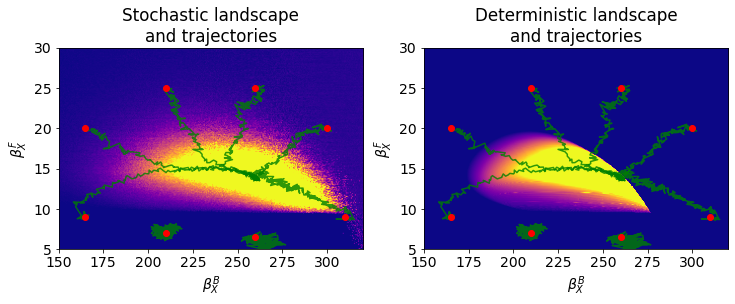

In [25]:
fig = plt.figure(figsize=(12, 5))

ax = [plt.subplot(1,2,i+1) for i in range(2)]

im = ['','']
im[0] = ax[0].imshow(PSDsto, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.06)
im[1] = ax[1].imshow(PSDdet, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.06)
tend = 200

for i in range(initial2Dlocations.shape[0]):
    
    ax[0].plot( summary[1, i, :tend, 1], summary[0, i, :tend, 1], color='g', alpha=0.8)
    ax[1].plot( summary[1, i, :tend, 1], summary[0, i, :tend, 1], color='g', alpha=0.8)

ax[0].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0], color='r',zorder=3000)
ax[1].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0], color='r',zorder=3000)

    
ax[0].set_xlim([betaBXmin, betaBXmax])
ax[0].set_ylim([betaFXmin, betaFXmax])

ax[1].set_xlim([betaBXmin, betaBXmax])
ax[1].set_ylim([betaFXmin, betaFXmax])

ax[0].set_title('Stochastic landscape\nand trajectories')
ax[1].set_title('Deterministic landscape\nand trajectories')

ax[0].set_xlabel('$\\beta^B_X$')
ax[0].set_ylabel('$\\beta^F_X$')

ax[1].set_xlabel('$\\beta^B_X$')
ax[1].set_ylabel('$\\beta^F_X$')


[1.38846858e+01 2.59313273e+02 1.18635861e+01 1.91783196e-01]
[1.37464819e+01 2.61412779e+02 7.16738694e+00 1.91049680e-01]
[1.36950237e+01 2.59255411e+02 7.96719342e+00 1.91703795e-01]
[1.37716779e+01 2.60332399e+02 1.03751017e+01 1.91523308e-01]
[1.36846939e+01 2.60631280e+02 1.03573374e+01 1.91782970e-01]
[  7.04098645 211.68014489   3.5193844    0.        ]
[  6.66638116 269.8680833    5.4450307    0.        ]
[1.44881852e+01 2.57812402e+02 3.00000000e+00 1.55760374e-01]


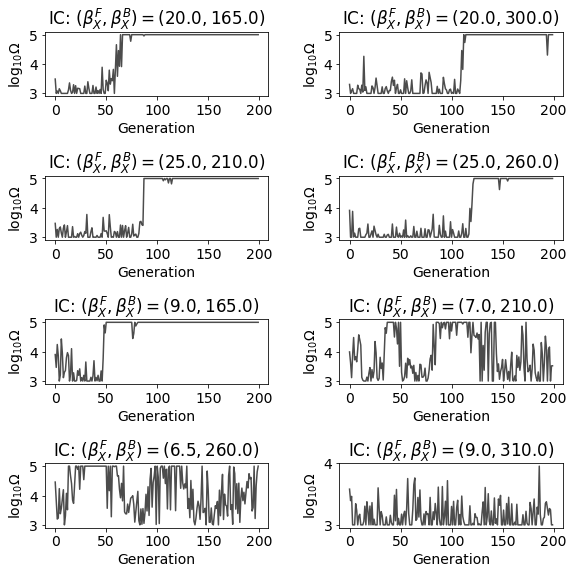

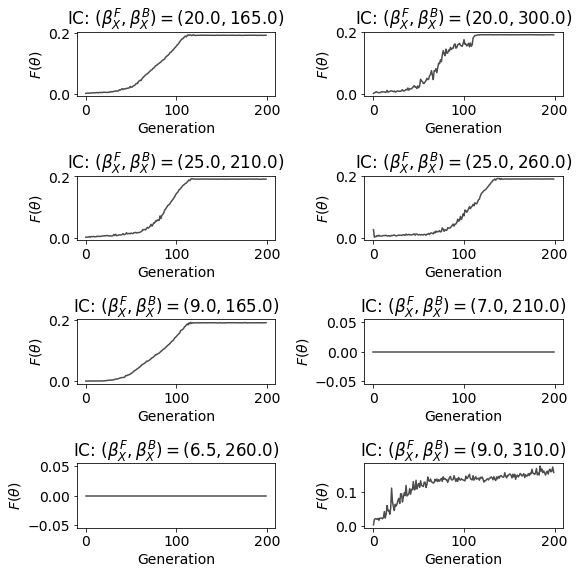

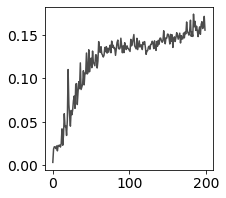

In [24]:
fig,ax = plt.subplots(4,2,figsize=[8.2,8.2])
fig2,ax2 = plt.subplots(4,2,figsize=[8.2,8.2])

fig3,ax3 = plt.subplots(1,1, figsize=(3,3))

bestPar = np.zeros(summary.shape[2])

bestFitness = np.zeros(summary.shape[2])



for i in range(len(initial2Dlocations)):    
    
    for j in range(summary.shape[2]):
        
        bestFitness[j] = np.amax(summary[3,i,j,:])
        index = np.where(summary[3,i,j,:]==bestFitness[j])[0][0]
        bestPar[j] = summary[2,i,j,index]
        bestFitness[j] = summary[3,i,j,index]
        
        if j == summary.shape[2]-1:
            print(summary[:,i,j,index]) 
        
    ax[i//2, i-2*(i//2)].plot(np.clip(bestPar[:tend], -np.inf, 5.0), color='k', alpha=0.7)
    
    ax[i//2, i-2*(i//2)].set_xlabel('Generation')
    ax[i//2, i-2*(i//2)].set_ylabel('$\\log_{10}\\Omega$')
    
    ax[i//2, i-2*(i//2)].set_title('IC: $(\\beta_X^F,\\beta_X^B)=('+str(initial2Dlocations[i,0])+','+str(initial2Dlocations[i,1])+')$')

    
    ax2[i//2, i-2*(i//2)].plot(np.clip(bestFitness[:tend], -np.inf, 4.0), color='k', alpha=0.7)
    ax2[i//2, i-2*(i//2)].set_xlabel('Generation')
    ax2[i//2, i-2*(i//2)].set_ylabel('$F(\\theta)$')
    ax2[i//2, i-2*(i//2)].set_title('IC: $(\\beta_X^F,\\beta_X^B)=('+str(initial2Dlocations[i,0])+','+str(initial2Dlocations[i,1])+')$')
    
    
ax3.plot(np.clip(bestFitness[:tend], -np.inf, 4.0), color='k', alpha=0.7)
    
fig.tight_layout()
fig2.tight_layout()